In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils


In [2]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super(Discriminator,self).__init__()
        #input N * channels_img * 64 *64
        self.disc = nn.Sequential(nn.Conv2d(channels_img,features_d,kernel_size = 4,stride = 2,padding = 1),
                                  # 32 *32
                                  nn.LeakyReLU(0.2),
                                  self._block(features_d,features_d*2,kernel_size=4,stride=2,padding=1), # 16*16
                                  self._block(features_d*2,features_d*4,kernel_size=4,stride=2,padding=1), # 8*8
                                  self._block(features_d*4,features_d*8,kernel_size=4,stride=2,padding=1), # 4*4
                                  nn.Conv2d(features_d*8,1,kernel_size = 4 , stride =2 ,padding = 0), #1*1
                                  nn.Sigmoid()
                                 )
        
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),nn.BatchNorm2d(out_channels),nn.LeakyReLU(0.2)) # bias=False because we use batch norm so it is useless param
        
    def forward(self,x):
        return self.disc(x)
    
class Generator(nn.Module):
    def __init__(self,channels_noise,channels_img,features_g):
        super(Generator,self).__init__()
        self.net = nn.Sequential(
            #input : N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            #output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), # because in generator DCGAN paper used ReLu
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [3]:
#hyperparameters etc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE=5e-5 #2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64


transforms_ = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.ImageFolder(root="emoji/", transform=transforms_)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100],padding=2,nrow=10, normalize=True).cpu(),(1,2,0)))

FileNotFoundError: [Errno 2] No such file or directory: 'emoji/'

In [4]:
gen = nn.DataParallel(Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN),device_ids=[0,1,2,3]).cuda()
disc = nn.DataParallel(Discriminator(CHANNELS_IMG, FEATURES_DISC),device_ids=[0,1,2,3]).cuda()
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0
# Lists to keep track of progress
img_list = []
g_losses = []
d_losses = []

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        step += 1
            
        g_losses.append(loss_gen)
        d_losses.append(loss_disc)
        # Check how the generator is doing by saving G's output on fixed_noise
        if (step % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (step == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))



NameError: name 'dataloader' is not defined

In [11]:
PATH = './model-gen_bitmoji.pth'
torch.save(gen, PATH)

In [72]:
PATH = './model-disc_bitmoji.pth'
torch.save(disc, PATH)

In [5]:
PATH = './Evalution/model-gen_bitmoji.pth'
gen = torch.load(PATH)
gen.eval()

DataParallel(
  (module): Generator(
    (net): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [7]:
PATH = './Evalution/model-disc_bitmoji.pth'
disc = torch.load(PATH)
disc.eval()

DataParallel(
  (module): Discriminator(
    (disc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (4): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (5): Conv2d(512, 1, kernel_siz

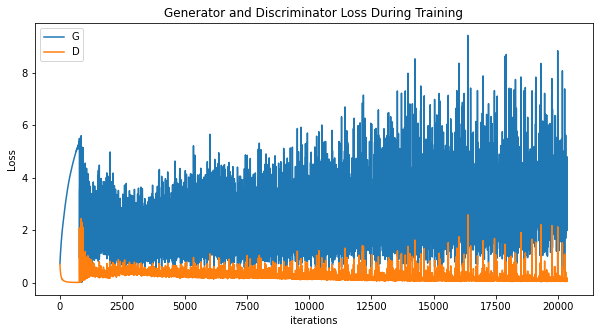

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


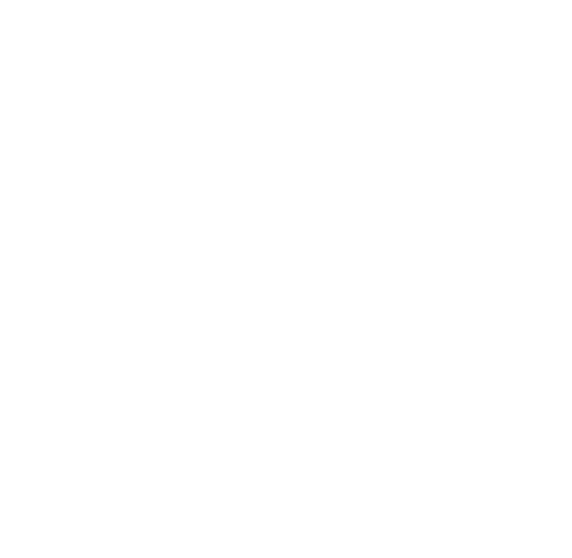

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discrimanator'output 0.11 


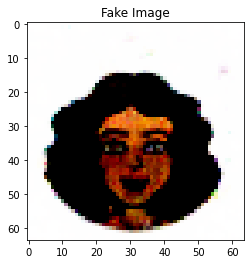

In [11]:
temp = torch.randn(1, Z_DIM, 1, 1).to(device)
temp_ans = gen(temp)
plt.title('Fake Image')
plt.imshow(np.transpose(temp_ans.detach().cpu()[0],(1,2,0)))
print(f'Discrimanator\'output {disc(temp_ans).reshape(-1).detach().cpu().numpy()[0]:.2f} ')

torch.Size([200, 3, 64, 64])


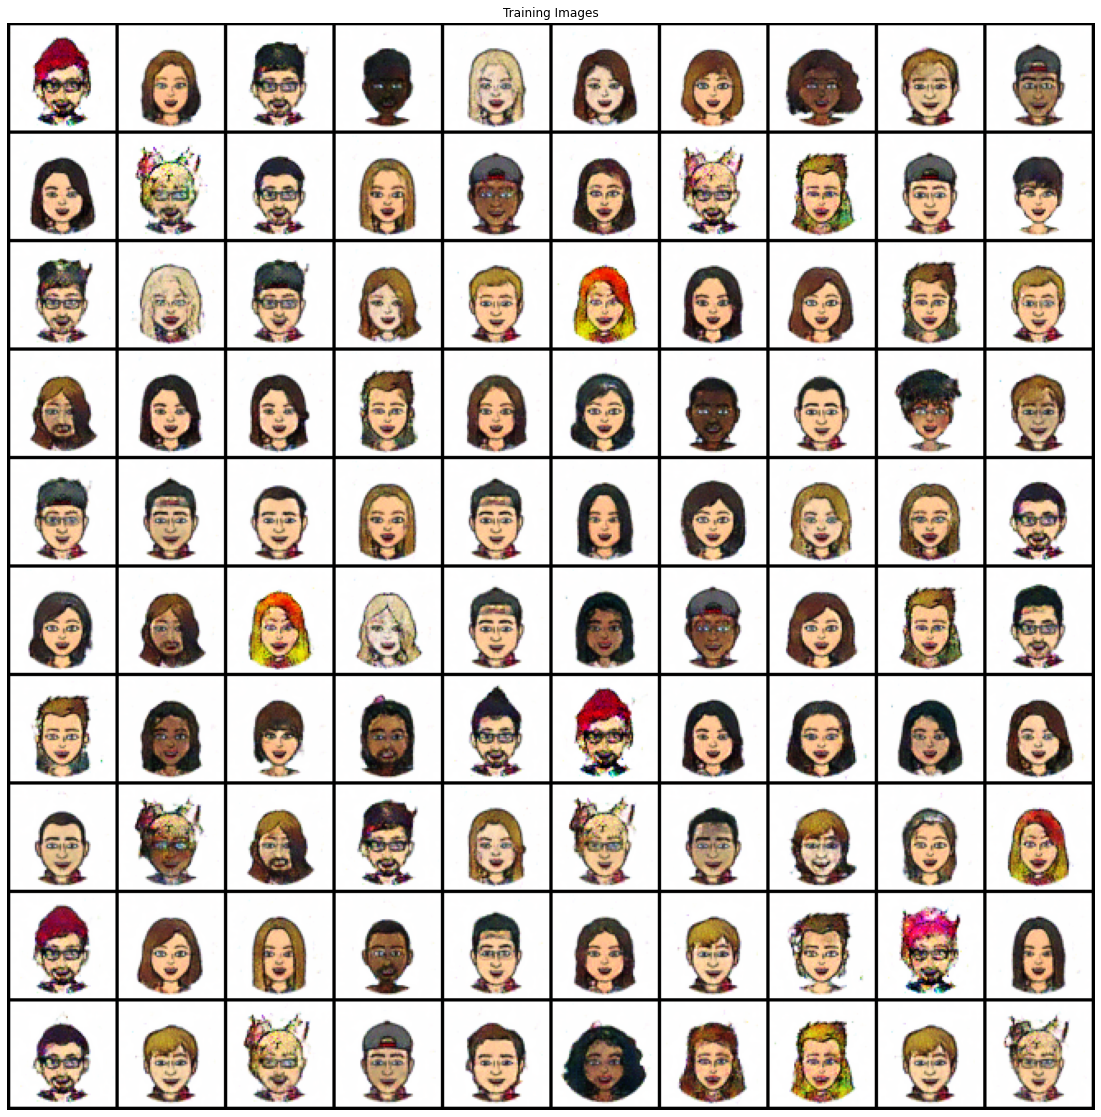

In [13]:
temp = torch.randn(200, Z_DIM, 1, 1).to(device)
temp_ans = gen(temp)

plt.figure(figsize=(20,20))
plt.axis("off")
plt.title("Training Images")
print(temp_ans.shape)
plt.imshow(np.transpose(vutils.make_grid(temp_ans.to(device)[:100],padding=2,nrow=10, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


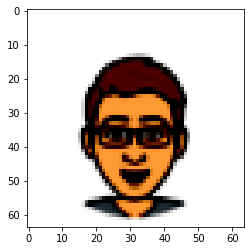

In [30]:
type(dataset[0][0])
plt.imshow(dataset[0][0].permute(1,2,0))

In [38]:
# metric = FID(num_features=1, feature_extractor=default_model)
# metric.attach(default_evaluator, "fid")
y_true = next(iter(dataloader))[0]
y_pred = gen(torch.randn(128, Z_DIM, 1, 1).to(device))
# state = default_evaluator.run([[y_pred, y_true]])
# print(state.metrics["fid"])

In [47]:
import  pytorch_fid as fid
# real_batch = next(iter(dataloader))
orig = list()
for i in dataset:
    orig.append(i[0].permute(1,2,0))
    if(len(orig)==1000):
        break
fake_imgs = gen(torch.randn(1000, Z_DIM, 1, 1).to(device))

In [54]:
import cv2
def save_img(inp, idx, path):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    cv2.imwrite(path+str(idx)+'.png', inp)
#saving original 1000 images
for idx,i in enumerate(dataset):
    save_img(i[0],idx,'./Evalution/orig/')
    if(idx==1000):
        break

In [68]:
fake_imgs = gen(torch.randn(1001, Z_DIM, 1, 1).to(device))
for idx,i in enumerate(fake_imgs):
    save_img(i.detach(),idx,'./Evalution/fake/')

In [2]:
!python -m pytorch_fid './Evalution/orig/' './Evalution/fake/'

100%|███████████████████████████████████████████| 21/21 [00:02<00:00, 10.16it/s]
FID:  3.400948181173959
